# HW1 - A Rather Weird Neural Network (partial solution)

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (07/02/2024)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Torch (tested on v1.13.0)
- Torchmetrics (tested on v0.11.0)

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
# Helper functions (additional file)
from helper_functions import *

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Dataset generation

The dataset that will be used in this notebook looks very similar to what we have studied in class, with a few differences however...

Let us run the dataset generation, using our helper function **create_dataset()**, below.

In [3]:
# Parameters for helper functions
# - Minimum and maximum values
eps = 1e-5
min_val = -1 + eps
max_val = 1 - eps
# - Number of samples in training set
n_points_train = 10000
# - Number of samples in test set
n_points_test = 1000
# - Number of samples in validation set
n_points_valid = 1000
# - Batch size for training dataloader
batch_size = 512

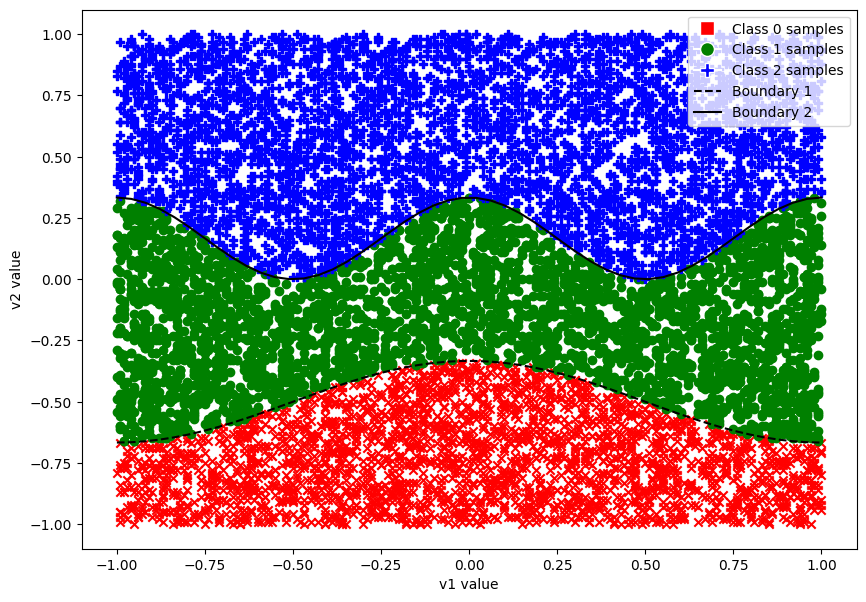

In [4]:
# Generate dataset (train)
np.random.seed(47)
train_val1_list, train_val2_list, train_inputs, train_outputs = create_dataset(n_points_train, min_val, max_val)
# Display training dataset
plot_dataset(min_val, max_val, train_val1_list, train_val2_list, train_outputs)

In [5]:
# Create train, test and validation dataloaders
train_loader, test_loader, valid_loader = generate_loaders(min_val, \
                                                           max_val, \
                                                           n_points_train, \
                                                           n_points_test, \
                                                           n_points_valid, \
                                                           batch_size, \
                                                           device)

### A Weird Activation Function

Let us consider the activation function, whose formula is given below

$$ f(x) = max \Big(0, \frac{2}{1 + exp(-x)} - 1 \Big) $$

In [6]:
def weird_function_np(x):
    return np.maximum(0, 2/(1 + np.exp(-x)) - 1)

<div class="alert alert-danger">
    On a side note, using the built-in max() instead of the numpy maximum() one would be considered a mistake, as it would not be able to operate with 2D arrays resulting from the Linear layers, later on.
</div>

In [7]:
def weird_function_np2(x):
    return max(0, 2/(1 + np.exp(-x)) - 1)

In [8]:
a = np.array([[0, 1],[-1, 2]])
y = weird_function_np2(a)
print(y)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

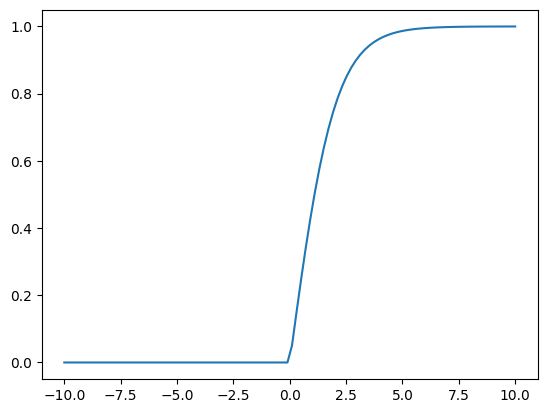

In [9]:
plt.plot(np.linspace(-10, 10, 100), [weird_function_np(x) for x in np.linspace(-10, 10, 100)])
plt.show()

### A Weird building block, using our weird activation function

The building block below should consist of a Linear layer with inputs dimension $ n_x $ and output dimension $ n_y $ followed by our weird activation function, that will be implemented in the **weird_function_torch()** method this time. 

In [10]:
class WeirdBlock(torch.nn.Module):
    def __init__(self, n_x = 2, n_y = 1):
        super().__init__()
        # Define Linear layer using the nn.Linear()
        self.fc = torch.nn.Linear(n_x, n_y)
        
    def weird_function_torch(self, x):
        val = 2/(1 + torch.exp(-x)) - 1
        return torch.max(torch.zeros(x.shape).to(x.device), val)
    
    def forward(self, x):
        # Our Weird operation
        z = self.fc(x)
        out = self.weird_function_torch(z)
        return out

### Building a Deep Neural Network

Let us now define our Deep Neural Network

For any given non-empty list of sizes in $ n_h $, we would like to use our WeirdBlock object from earlier.
- The first layer, will consist of a WeirdBlock with input size $ n_x $ and output size $ n_h[0] $,
- Every consecutive layer will consist of a WeirdBlock with input size $ n_h[i] $ and output size $ n_h[i+1] $ (until the list $ n_h $ runs out of elements
- Eventually, the last layer will consist of a simple Linear layer, with input size $ n_h[-1] $ and output size $ n_y $.

In [11]:
class DeepNeuralNet(torch.nn.Module):
    def __init__(self, n_x = 2, n_h = [10], n_y = 3):
        super().__init__()
        # Define the correct number of layers based on n_h,
        # Use the correct number of WeirdBlock layers,
        # And finish with a single Linear layer
        values = [n_x] + n_h
        self.processing_layers = [WeirdBlock(values[i], values[i + 1]) for i in range(len(values) - 1)]
        self.processing_layers += [torch.nn.Linear(n_h[-1], n_y)]
        
        # Combine all layersc
        # Important: note the * symbol before the list of layers in self.processing_layers
        # Not sure what it does? Check the *args and **kwargs concepts in Python.
        self.combined_layers = torch.nn.Sequential(*self.processing_layers)
    
    def forward(self, x):
        # Pass through all four layers
        out = self.combined_layers(x)
        return out

If you have correctly figured out the code above, the cell below should produce an output, which looks like:

```
<bound method Module.modules of DeepNeuralNet(
  (combined_layers): Sequential(
    (0): WeirdBlock(
      (fc): Linear(in_features=2, out_features=10, bias=True)
    )
    (1): WeirdBlock(
      (fc): Linear(in_features=10, out_features=5, bias=True)
    )
    (2): Linear(in_features=5, out_features=3, bias=True)
  )
)>
```

In [12]:
# Initialize the model
torch.manual_seed(43)
model = DeepNeuralNet(n_x = 2, n_h = [10, 5], n_y = 3).to(device)
# This will display a recap of the different layers
print(model.modules)

<bound method Module.modules of DeepNeuralNet(
  (combined_layers): Sequential(
    (0): WeirdBlock(
      (fc): Linear(in_features=2, out_features=10, bias=True)
    )
    (1): WeirdBlock(
      (fc): Linear(in_features=10, out_features=5, bias=True)
    )
    (2): Linear(in_features=5, out_features=3, bias=True)
  )
)>


In [13]:
def predict(model, inputs, device):
    outputs = model(inputs)
    max_probability, predicted = torch.max(outputs.data, 1)
    # predicted = torch.argmax(outputs.data, 1)
    return outputs, predicted

If the **predict()** function has been correctly implemented, it should return
- the following values for **outputs.data**:
```
[[-0.0924,  0.3132,  0.4449],
[-0.0867,  0.3166,  0.4524],
[-0.0800,  0.3242,  0.4656],
[-0.0663,  0.3089,  0.4701],
[-0.0792,  0.3162,  0.4603],
[-0.0759,  0.3119,  0.4612],
[-0.0741,  0.3081,  0.4613],
[-0.0770,  0.3078,  0.4581],
[-0.0938,  0.3128,  0.4425],
[-0.0872,  0.3077,  0.4472]]
```
- the following values for **predicted.data**:
```
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
```

In [14]:
# Initialize the model
torch.manual_seed(43)
model = DeepNeuralNet(n_x = 2, n_h = [10, 5], n_y = 3).to(device)
for batch in train_loader:
    inputs, outputs = batch
    outputs, predicted = predict(model, inputs[0:10, :], device)
    print(outputs.data)
    print(predicted.data)
    break

tensor([[-0.0924,  0.3132,  0.4449],
        [-0.0867,  0.3166,  0.4524],
        [-0.0800,  0.3242,  0.4656],
        [-0.0663,  0.3089,  0.4701],
        [-0.0792,  0.3162,  0.4603],
        [-0.0759,  0.3119,  0.4612],
        [-0.0741,  0.3081,  0.4613],
        [-0.0770,  0.3078,  0.4581],
        [-0.0938,  0.3128,  0.4425],
        [-0.0872,  0.3077,  0.4472]], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [15]:
def define_optimizer(model, lr, alpha):
    # Define optimizer
    optimizer = torch.optim.RMSprop(model.parameters(), lr = lr, alpha = alpha)
    optimizer.zero_grad()
    return optimizer

If you have correctly implemented the code above, the cell below should display
```
RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    momentum: 0
    weight_decay: 0
)
```

In [16]:
optimizer = define_optimizer(model, lr = 0.01, alpha = 0.99)
print(optimizer)

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)


### Training the Deep Neural Network

The correct trainer function should look like this.

In [17]:
def trainer(model, train_loader, test_loader, valid_loader, num_epochs = 10, lr = 0.1, alpha = 0.99):
    
    # History for train acc, test acc
    train_accs = []
    valid_accs = []
    
    # Define optimizer
    optimizer = define_optimizer(model, lr, alpha)
    
    # Training model
    for epoch in range(num_epochs):
        # Go trough all samples in train dataset
        model.train()
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.reshape(-1).to(device)

            # Forward pass
            outputs, predicted = predict(model, inputs, device)
            
            # Check if predicted class matches label and count numbler of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Compute loss
            loss = torch.nn.functional.cross_entropy(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Display losses over iterations and evaluate on validation set
            if (i+1) % 10 == 0:
                train_accuracy, valid_accuracy = display_train(epoch, num_epochs, i, model, \
                                                               correct, total, loss, \
                                                               train_loader, valid_loader, device)
                
        # Append accuracies to list at the end of each iteration
        train_accs.append(train_accuracy)
        valid_accs.append(valid_accuracy)
        
    # Evaluate on test after training has completed
    test_acc = eval_test(model, test_loader, device)
        
    # Return
    return train_accs, valid_accs, test_acc

After you have completed the blanks in all questions, you should be able to run the two cells below.

In [18]:
torch.manual_seed(43)
model = DeepNeuralNet(n_x = 2, n_h = [20, 10], n_y = 3).to(device)
train_accs, valid_accs, test_acc = trainer(model, train_loader, test_loader, valid_loader, \
                                           num_epochs = 50, lr = 0.1, alpha = 0.99)

Epoch [1/50], Step [10/20], Train Loss: 0.7661
Epoch [1/50], Train Accuracy: 0.4902
Epoch [1/50], Validation Accuracy: 0.6720
Epoch [1/50], Step [20/20], Train Loss: 0.6491
Epoch [1/50], Train Accuracy: 0.5816
Epoch [1/50], Validation Accuracy: 0.6390
Epoch [2/50], Step [10/20], Train Loss: 0.5877
Epoch [2/50], Train Accuracy: 0.6848
Epoch [2/50], Validation Accuracy: 0.6720
Epoch [2/50], Step [20/20], Train Loss: 0.4877
Epoch [2/50], Train Accuracy: 0.6813
Epoch [2/50], Validation Accuracy: 0.6720
Epoch [3/50], Step [10/20], Train Loss: 0.5404
Epoch [3/50], Train Accuracy: 0.6803
Epoch [3/50], Validation Accuracy: 0.6810
Epoch [3/50], Step [20/20], Train Loss: 0.5146
Epoch [3/50], Train Accuracy: 0.6805
Epoch [3/50], Validation Accuracy: 0.6820
Epoch [4/50], Step [10/20], Train Loss: 0.5333
Epoch [4/50], Train Accuracy: 0.6752
Epoch [4/50], Validation Accuracy: 0.6930
Epoch [4/50], Step [20/20], Train Loss: 0.5027
Epoch [4/50], Train Accuracy: 0.6844
Epoch [4/50], Validation Accuracy:

Epoch [34/50], Step [10/20], Train Loss: 0.0328
Epoch [34/50], Train Accuracy: 0.9854
Epoch [34/50], Validation Accuracy: 0.9860
Epoch [34/50], Step [20/20], Train Loss: 0.0642
Epoch [34/50], Train Accuracy: 0.9854
Epoch [34/50], Validation Accuracy: 0.9630
Epoch [35/50], Step [10/20], Train Loss: 0.0279
Epoch [35/50], Train Accuracy: 0.9852
Epoch [35/50], Validation Accuracy: 0.9950
Epoch [35/50], Step [20/20], Train Loss: 0.0659
Epoch [35/50], Train Accuracy: 0.9838
Epoch [35/50], Validation Accuracy: 0.9940
Epoch [36/50], Step [10/20], Train Loss: 0.0469
Epoch [36/50], Train Accuracy: 0.9777
Epoch [36/50], Validation Accuracy: 0.9950
Epoch [36/50], Step [20/20], Train Loss: 0.0184
Epoch [36/50], Train Accuracy: 0.9802
Epoch [36/50], Validation Accuracy: 0.9820
Epoch [37/50], Step [10/20], Train Loss: 0.0350
Epoch [37/50], Train Accuracy: 0.9914
Epoch [37/50], Validation Accuracy: 0.9760
Epoch [37/50], Step [20/20], Train Loss: 0.0201
Epoch [37/50], Train Accuracy: 0.9876
Epoch [37/5

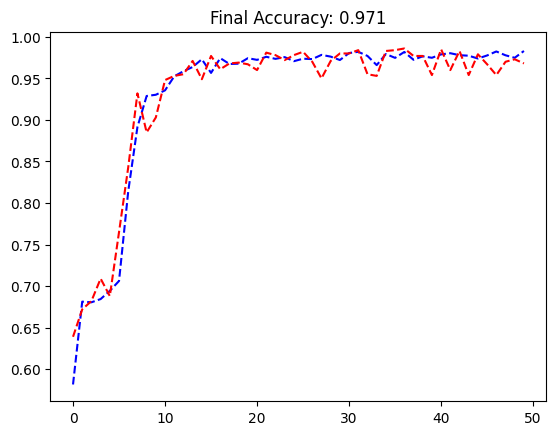

In [19]:
plt.plot(train_accs, "b--")
plt.plot(valid_accs, "r--")
plt.title("Final Accuracy: {}".format(test_acc))
plt.show()

### Up for a challenge?

**Challenge:** After training using the suggested parameters, you should normally obtain a test accuracy of 97% or so.

Could you suggest things to do to improve this score further and possibly bring it towards 100%?

Showing code of a Neural Network that achieves a 99.5+% accuracy on the test set would be nice.

<div class="alert alert-danger">
    This is a rather open question, waiting for students to explore what can be done with said Neural Network. Solutions include: using more layers, using a more conventional activation function (sigmoid works great here, but it somewhat defeats the purpose of this activity and using the weird activation function), tuning hyperparameters (learning rate, alpha coefficient in RMSprop, etc.), using a different optimizers, implementing an early stopping based on the test accuracy, etc.
    It should be noted that the smartest approach would, as in Week 2 NB 8, consist of feature engineering. Based on the boundary equations, adding two values for $ cos(\pi val_1) $ and $ cos (2\pi val_1) $ seems like a very good idea. Some students tried using $ sin(val_1) $ with limited results, which is expected given that the boundary equation did not rely on the sine function.
</div>

### Final remarks

Assemble all your answers and code snippets in a small PDF report. It should be submitted on eDimension.

Submitting your modified notebook, along with the PDF report, would also be nice, especially if you plan to show code for Question 10.